Time Series Analysis
====================



## Pre-analysis thoughts on the data and its format



-   heart rate
    sampling rate is ~9Hz
    On its own, this will give the rough stress of the activity; it wouldn&rsquo;t surprise me if even just averaging this could tell you what activity they&rsquo;re doing
-   imu: temp, acceleration at several resolutions, gyroscope, magnetometer, orientation, across several locations
    sampling frequency is 100Hz, so roughly 10x the heart rate data
    -   chest
        The lowest frequency of these sensors, it should easily distinguish cycling from the rest, probably most clearly when starting or stopping in the acceleration
    -   ankle
        proxy for gait, should be fairly high frequency, and useful for distinguishing several signal types
    -   hand
        I haven&rsquo;t thought enough about the domain to know for certain how this goes. Guessing it might actually be lower amplitude for running than any of the walking

There are 9 subjects, with only one female subject, which is an unfortunate skew. Age is more consistent around 27.



## Packages used



Scipy has a signal processing toolbox, which will probably be useful in this context. Pandas is useful to manage the labels of the data and filtering. I figure pywavelets may be useful, depending on how gnarly the signals are, and I recently learned about fCWT, so I wanted to test that out a bit. For classification we&rsquo;ll eventually want scikit-learn. Seaborn supposedly has good plotting interactions with Pandas, so that&rsquo;s also going in here.



In [5]:
%matplotlib inline
import pywt
import fcwt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import interpolate
import sklearn
from sklearn import linear_model
import pandas as pd

## Initial processing



First, we define a function to load a particular subject and set, and then one to make a full table.
The raw data has a couple of invalid columns, which we need to drop, as well as transition activities with `activityID=0` that we need to drop.
To deal with disconnected devices returning `NaN`, we do some cubic spline interpolation, and include a flag to warn the user if there&rsquo;s a significant number of `NaN` in a particular table, and return a boolean matrix indicating former `NaN` locations.

The Heart rate data in particular has many ~NaN~s, since it&rsquo;s sampled at ~1/10th the frequency of the other data. Given that it is a much lower frequency signal to begin with however (a high heart rate of 180bpm is only a 3Hz signal), this interpolation should cause no problems.

Finally, `cols` gives the column labels after dropping the orientation data from the hand, chest and ankle IMU. `* small *` can probably be ignored, as it&rsquo;s scale was $\pm 6g$, which is apparently easily saturated by some activities in the dataset.
Leaving it in as something to be explored however.

In addition, I&rsquo;m going to add a couple of variables: since the direction probably matters less than the total acceleration, `chest`, `hand` and `ankle` give the magnitude of the vector `('chest x', 'chest y', 'chest z')`. Similar stats for `small`, `gyro`, and `magne`.



In [6]:
cols = ['time', 'activity', 'heart rate (bpm)', 'hand temperature', 'hand x', 'hand y', 'hand z', 'hand small x', 'hand small y', 'hand small z', 'hand gyro x',  'hand gyro y',  'hand gyro z',  'hand magne x',  'hand magne y',  'hand magne z', 'chest temperature', 'chest x', 'chest y', 'chest z', 'chest small x', 'chest small y', 'chest small z', 'chest gyro x',  'chest gyro y',  'chest gyro z',  'chest magne x',  'chest magne y',  'chest magne z', 'ankle temperature', 'ankle x', 'ankle y', 'ankle z', 'ankle small x', 'ankle small y', 'ankle small z', 'ankle gyro x',  'ankle gyro y',  'ankle gyro z',  'ankle magne x',  'ankle magne y',  'ankle magne z']
def load_subject(subject_number, dataset):
    """initial cleaning function"""
    raw = np.loadtxt(f"PAMAP2_Dataset/{dataset}/subject10{subject_number}.dat")
    # drop the orientation data (rows 16:20, 33:37, and 50:54), as they're invalid
    basic = raw[:,np.r_[:16, 20:33, 37:50]]
    # drop all activities labeled 0, as these are transient
    basic = basic[basic[:,1] != 0]
    n_samples,n_sensors = basic.shape
    # keep a record of where all the NaN's are, in case there are runs that are too large and we need to drop data
    nans = np.isnan(basic)
    n_nans = np.isnan(basic).sum(0)/n_samples
    # do some interpolation using scipy to fill in the NaNs using neighboring points; using cubic splines, which is probably a little overkill.
    for col_ii in range(2,basic.shape[1]):
        non_nan_times = basic[np.logical_not(nans[:,col_ii]), 0]
        non_nan = basic[np.logical_not(nans[:,col_ii]), col_ii]
        interpolator = interpolate.interp1d(non_nan_times, non_nan, kind="cubic", axis=0, fill_value='extrapolate')
        basic[nans[:, col_ii], col_ii] = interpolator(basic[nans[:, col_ii], 0]) # fill in the original data matrix NaNs with interpolated values
        if col_ii>2 and n_nans[col_ii] > .01:
            print(f"warning: more than 1% of the data for {cols[col_ii]} is NaNs")
    frame = pd.DataFrame(basic, columns = cols)

    # generating the magnitude of the accelerometers; I found out that using frame.apply(np.norm(1)) performed absolutely abysmally, so doing it the manual way
    frame['hand'] = np.sqrt(np.square(frame[['hand x', 'hand y', 'hand z']]).sum(1))
    frame['chest'] = np.sqrt(np.square(frame[['chest x', 'chest y', 'chest z']]).sum(1))
    frame['ankle'] = np.sqrt(np.square(frame[['ankle x', 'ankle y', 'ankle z']]).sum(1))

    frame['hand small'] = np.sqrt(np.square(frame[['hand small x', 'hand small y', 'hand small z']]).sum(1))
    frame['chest small'] = np.sqrt(np.square(frame[['chest small x', 'chest small y', 'chest small z']]).sum(1))
    frame['ankle small'] = np.sqrt(np.square(frame[['ankle small x', 'ankle small y', 'ankle small z']]).sum(1))

    frame['hand gyro'] = np.sqrt(np.square(frame[['hand gyro x', 'hand gyro y', 'hand gyro z']]).sum(1))
    frame['chest gyro'] = np.sqrt(np.square(frame[['chest gyro x', 'chest gyro y', 'chest gyro z']]).sum(1))
    frame['ankle gyro'] = np.sqrt(np.square(frame[['ankle gyro x', 'ankle gyro y', 'ankle gyro z']]).sum(1))

    frame['hand magne'] = np.sqrt(np.square(frame[['hand magne x', 'hand magne y', 'hand magne z']]).sum(1))
    frame['chest magne'] = np.sqrt(np.square(frame[['chest magne x', 'chest magne y', 'chest magne z']]).sum(1))
    frame['ankle magne'] = np.sqrt(np.square(frame[['ankle magne x', 'ankle magne y', 'ankle magne z']]).sum(1))
    return frame, pd.DataFrame(n_nans[np.newaxis, :], columns = cols)
def full_table():
    """create a data frame containing every subject and source; needs additional columns denoting the subject id and whether its the main examples or the optional ones"""
    full_frame = pd.DataFrame()
    full_frame, full_nans = load_subject(1, "Protocol")
    full_frame['subject'] = 1
    full_frame['Protocol'] = True
    full_nans['subject'] = 1
    full_nans['Protocol'] = True
    for subject_ii in range(2,10):
        tmp_frame, tmp_nans = load_subject(subject_ii, "Protocol")
        tmp_frame['subject'] = subject_ii
        tmp_frame['Protocol'] = True
        tmp_nans['subject'] = subject_ii
        tmp_nans['Protocol'] = True
        full_frame = pd.concat([full_frame, tmp_frame])
        full_nans = pd.concat([full_nans, tmp_nans])
    for subject_ii in [1,5,6,8,9]:
        tmp_frame, tmp_nans = load_subject(subject_ii, "Optional")
        tmp_frame['subject'] = subject_ii
        tmp_frame['Protocol'] = False
        tmp_nans['subject'] = subject_ii
        tmp_nans['Protocol'] = False
        full_frame = pd.concat([full_frame, tmp_frame])
        full_nans = pd.concat([full_nans, tmp_nans])
    return full_frame, full_nans
frame, nans = full_table()

thankfully, none of the non-heart rate variables have more than 1% `NaN`, so we don&rsquo;t need to remove any of the data for now.



In [7]:
frame

,time,activity,heart rate (bpm),hand temperature,hand x,hand y,hand z,hand small x,hand small y,hand small z,...,chest small,ankle small,hand gyro,chest gyro,ankle gyro,hand magne,chest magne,ankle magne,subject,Protocol
0,37.66,1.0,100.106697,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.822404,9.796073,0.039483,0.066375,0.027921,71.369737,67.332172,92.196177,1,True
1,37.67,1.0,100.071815,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.852047,9.748582,0.173852,0.067424,0.021749,71.745163,66.692157,91.833822,1,True
2,37.68,1.0,100.042679,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.873164,9.764360,0.238506,0.060338,0.063439,70.749974,67.164701,91.415884,1,True
3,37.69,1.0,100.018877,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.865334,9.756044,0.194311,0.090952,0.046244,71.198631,66.494381,91.755312,1,True
4,37.70,1.0,100.000000,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.817284,9.809110,0.072467,0.041521,0.049304,70.716057,66.439341,91.396062,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158868,1936.14,20.0,177.998621,24.875,-6.42779,6.84232,2.80728,-6.52140,6.75658,2.56787,...,9.810042,9.867270,0.117788,0.161901,0.021327,54.975891,50.736188,51.023924,9,False
158869,1936.15,20.0,177.997952,24.875,-6.39107,6.69028,2.80834,-6.55066,6.75689,2.67360,...,9.760977,9.866938,0.110464,0.127745,0.055200,55.690979,50.253302,50.359110,9,False
158870,1936.16,20.0,177.997164,24.875,-6.41763,6.57977,3.15471,-6.53586,6.56061,2.84013,...,9.734297,9.857776,0.090651,0.172837,0.063669,54.701982,49.822665,51.166757,9,False
158871,1936.17,20.0,177.996250,24.875,-6.46049,6.42730,3.03912,-6.55081,6.53056,2.88551,...,9.577592,9.872424,0.085489,0.162392,0.038844,55.171737,49.673237,50.788652,9,False


### Extra labels



In addition, lets create much coarser labels that correspond to inactive (0), active (1), and exercise (2). `coarser_map[i]` gives the integer corresponding to the coarser label.



In [8]:
activity_labels = {1: 'lying', 2:'sitting', 3:'standing', 17:'ironing', 16:'vacuuming', 12:'ascending stairs', 13:'descending stairs', 4:'normal walking', 7:'Nordic walking', 6:'cycling', 5:'running', 24:'rope jumping', 9:'watching tv', 10:'computer work', 11:'car driving', 18:'folding laundry', 19:'house cleaning', 20:"playing soccer"}
activity_labels_reversed = {v : k for k,v in activity_labels.items()}
coarser_labels = {1: 0, 2: 0, 3: 0, 17: 1, 16: 1, 12: 2, 13: 2, 4: 1, 7: 2, 6: 2, 5: 2, 24: 2, 9: 0, 10: 0, 11: 0, 18: 1, 19: 1, 20: 2}
coarser_labels_names = {0: "inactive", 1 : "active", 2:"exercise"}

# actually adding them into the frame
frame['activity label'] = frame['activity'].map(activity_labels)
frame['coarse activity'] = frame['activity'].map(coarser_labels)
frame['coarse activity label'] = frame['coarse activity'].map(coarser_labels_names)

## Simple Summary statistics



To start with, let&rsquo;s look at the summary statistics, as separated by the activity.



In [9]:
summary_stats = frame.drop(['time', 'activity', 'coarse activity', 'coarse activity label'],axis=1).groupby('activity label').describe()

Here we have the averages per activity for heartrate. Running, rope jumping, and playing soccer are all outliers at 156 to 168, though they are also somewhat on the low end of number of samples. Interestingly, all categories are roughly within one standard deviation of one another, so heart rate alone will probably not be enough to distinguish fine-grained activities.



In [10]:
summary_stats['heart rate (bpm)'].sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
activity label,,,,,,,,
lying,192523.0,75.536043,10.536810,56.892348,69.995304,73.995304,80.998869,115.107744
computer work,309935.0,75.729955,8.315868,59.890326,69.000000,73.006281,83.000000,102.107656
sitting,185188.0,80.013060,8.008474,62.891149,75.000000,78.999959,83.984519,113.107744
watching tv,83646.0,83.407133,5.521208,74.892348,80.239726,82.000000,84.005870,109.107661
standing,189931.0,88.554788,10.010566,67.892312,80.999996,88.612543,96.340207,112.107744
ironing,238690.0,90.062311,8.929636,68.891149,84.998493,88.905576,93.996939,122.107698
folding laundry,99878.0,90.269954,11.506504,69.892256,78.000000,91.984245,97.064489,117.107655
house cleaning,187188.0,96.417751,13.479741,67.915654,87.000000,94.000000,106.000590,128.107658
car driving,54519.0,103.066983,7.304963,88.891073,98.383478,102.000000,106.119340,128.122493


Mostly out of curiosity, lets take a look at the temperature reading from the hand IMU:



In [11]:
summary_stats['hand temperature'].sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
activity label,,,,,,,,
playing soccer,46915.0,27.270159,2.779595,24.874921,25.0625,25.1875,30.7500,30.812506
rope jumping,49360.0,29.720052,2.490725,24.875000,28.4375,30.1875,30.8125,33.875001
running,98199.0,30.818058,2.086611,27.500000,28.8125,30.8125,33.8125,33.875000
cycling,164600.0,31.008824,1.997441,27.562500,29.3125,31.0625,32.7500,34.687500
Nordic walking,188107.0,31.534647,1.755120,28.937500,30.3125,30.7500,33.0000,34.938604
computer work,309935.0,32.114982,1.214480,29.000000,31.2500,32.1250,33.0000,34.500000
normal walking,238761.0,32.300379,1.382759,28.687500,31.3750,32.5625,33.0625,34.875000
lying,192523.0,32.726154,1.405145,30.187500,31.3125,32.8750,33.8125,34.937500
sitting,185188.0,33.262085,1.103127,31.500000,32.1250,33.5000,34.2500,35.062500


For comparison, the [average human body temperature](https://en.wikipedia.org/wiki/Human_body_temperature) is 36.5–37.5 °C, so even the highest hand measurement is lower than one&rsquo;s core body temperature. Hand temperature roughly negatively correlate with activity; as you exercise, your body draws blood out of your periphery and into your core and muscles. Interestingly, the chest temperature, while generally closer to the actual core temperature, is still lower. Unsure if that&rsquo;s because I&rsquo;m mistaken about the blood-flow, or if the sensor is still only getting a skin temperature reading.



In [12]:
summary_stats['chest temperature'].sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
activity label,,,,,,,,
playing soccer,46915.0,33.212884,0.805097,32.31250,32.5625,32.6875,34.2500,34.250000
rope jumping,49360.0,33.605086,1.472824,31.93750,32.1875,33.7500,34.1250,36.500000
computer work,309935.0,33.845430,1.275583,31.12500,32.8750,33.8750,34.8750,36.250000
running,98199.0,34.398012,1.428991,32.06250,33.3750,34.0625,36.3750,36.812500
lying,192523.0,35.087787,1.560122,32.18750,33.6250,34.9375,36.6875,37.437500
cycling,164600.0,35.725755,1.602098,32.81250,34.5000,35.3750,37.3750,38.312500
sitting,185188.0,35.824338,1.255412,33.68750,34.7500,35.7500,37.0000,37.625000
house cleaning,187188.0,36.037150,1.085068,33.93750,35.0625,36.0625,37.1875,37.500000
Nordic walking,188107.0,36.158435,1.675612,33.74999,34.8125,35.6875,38.3125,38.577874


Turning to the acceleration data, first lets look at the movement of the core



In [13]:
summary_stats['chest'].sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
activity label,,,,,,,,
lying,192523.0,9.587474,0.293785,3.864523,9.460779,9.567980,9.683376,22.425921
watching tv,83646.0,9.715500,0.205635,7.434601,9.618258,9.723783,9.812081,14.491353
sitting,185188.0,9.819690,0.300539,5.138014,9.713096,9.802401,9.902520,16.506993
standing,189931.0,9.836934,0.269169,3.032830,9.721561,9.815770,9.932196,18.610969
computer work,309935.0,9.843228,0.255740,3.261755,9.690674,9.819635,10.008822,19.007271
ironing,238690.0,9.956556,0.326937,2.583077,9.789140,9.941560,10.105507,16.804097
car driving,54519.0,9.968828,0.448085,0.811480,9.754746,9.933963,10.151250,15.466242
folding laundry,99878.0,9.973617,0.461190,5.824929,9.736265,9.927671,10.155044,15.642570
house cleaning,187188.0,10.021077,0.918631,2.009884,9.658685,9.929600,10.272134,54.126240


One thing to notice is that the highest mean value activities also have the largest standard deviation, and even lying down has a max value that is higher than the typical mean. This is data that the average value obscures the important time variation.
A surprising observation is that driving has both a relatively low mean and standard deviation; the smooth acceleration of the car must be significantly less than the rapidly vertically shifting rope jumping. The highest value for rope jumping is 155, a whole order of magnitude greater than its mean! This suggests the signals are quite non-smooth, which lends itself to wavelet analysis.

Turning to the hand sensor data, this shows similar variation, with even higher max values, this time in soccer and running; for soccer this makes sense, as one frequently needs to make quick cuts, which can move your hands jerkily. I&rsquo;m somewhat surprised that running has the same pattern, and that rope jumping is &ldquo;only&rdquo; 174.



In [14]:
summary_stats['hand'].sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
activity label,,,,,,,,
computer work,309935.0,9.727158,0.501489,2.994510,9.597124,9.703476,9.816248,53.464097
lying,192523.0,9.728174,0.536339,2.365078,9.622836,9.704683,9.790422,59.326403
sitting,185188.0,9.760337,0.786686,1.056083,9.641148,9.734970,9.828852,152.245999
watching tv,83646.0,9.781914,0.329989,2.083712,9.717247,9.776557,9.833766,24.270579
standing,189931.0,9.783620,0.741341,0.671031,9.643139,9.747043,9.853661,50.794843
car driving,54519.0,9.924075,1.387874,1.364018,9.480332,9.771636,10.143078,67.691678
ironing,238690.0,10.018180,1.605587,0.569730,9.374962,9.839169,10.459946,50.921455
folding laundry,99878.0,10.287894,2.607382,0.599666,8.991917,9.942293,11.181271,66.033619
descending stairs,104944.0,10.341806,3.795485,0.280840,8.118465,9.780045,11.855787,150.270548


## Plotting utilities



We begin by making a function that compresses selecting by activity and subject, since we&rsquo;ll want to do that fairly frequently, and using that to plot a running heartrate vs a cycling one



In [15]:
%matplotlib inline
def subject_activity(subjectID, activity_name):
    return (frame['activity'] == activity_labels_reversed[activity_name]) & (frame['subject']==subjectID)
def plot_activity_comparison(activity_name_1, activity_name_2, sensor):
    """compare two activities for a given sensor across all subjects as raw timeseries"""
    for subject in range(9):
        select_one = subject_activity(subject,activity_name_1)
        select_two = subject_activity(subject,activity_name_2)
        time = frame['time'].loc[select_one]
        start_time = time.min()
        plt.plot(time -start_time, frame[sensor].loc[select_one], label=f"{subject} {activity_name_1}", color="red")
        time = frame['time'].loc[select_two]
        start_time = time.min()
        plt.plot(time - start_time, frame[sensor].loc[select_two], label=f"{subject} {activity_name_2}", color="blue")
        plt.legend(fontsize='xx-small')

## Pairwise time series comparisons



First, lets compare walking and running using the heartrate, we see that the two are visually obvious, as was reflected in the mean value above.



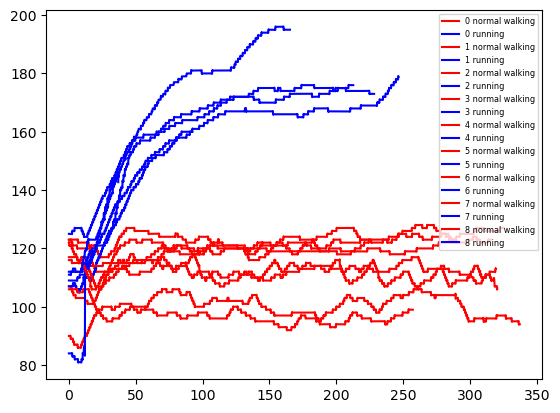

In [16]:
plot_activity_comparison('normal walking', 'running', 'heart rate (bpm)')

A somewhat harder example would be running vs cycling, which has a mean difference of ~25bpm. Below, once the initial starting period is over, the two series cleanly separate.



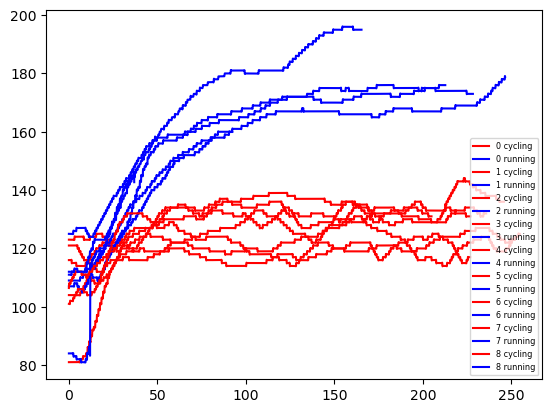

In [17]:
plot_activity_comparison('cycling', 'running', 'heart rate (bpm)')

If it were competitive rather than practical cycling, I suspect this gap would be much smaller; the description from the data set is
> cycling: was performed outside with a real bike with slow to moderate pace, as if the subject would
> bike to work or bike for pleasure (but not as a sport activity)For a harder example, let&rsquo;s compare nordic walking and normal walking. It is clearly distinguishable for any given individual, but the person exerting the least during Nordic walking, and the person exerting the most during normal walking definitely overlap. I suspect some of the participants&rsquo; have normal walking speeds that are quite aggressive, and others didn&rsquo;t treat nordic walking as a competitive sport (the description states that none of the subjects knew what it was beforehand).



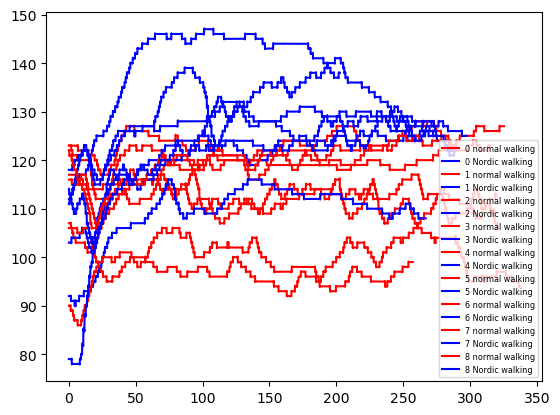

In [18]:
plot_activity_comparison('normal walking', 'Nordic walking', 'heart rate (bpm)')

Moving on to the IMU, we get signals that are fairly impenetrable in the time domain:



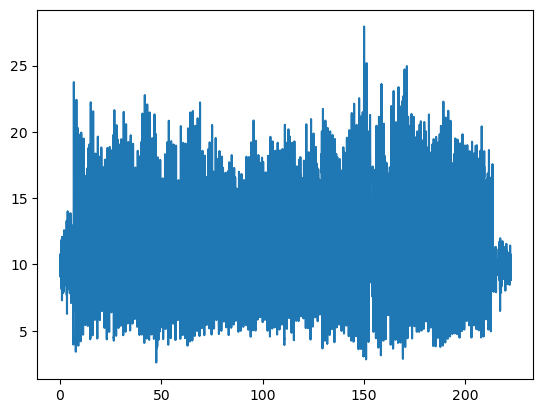

In [19]:
one_walking =  subject_activity(1,'normal walking')
time = frame['time'].loc[one_walking]
time = time - time.min()
plt.plot(time, frame["hand"].loc[one_walking])

So let&rsquo;s switch over to using a fast wavelet transform, which lets us plot the magnitude of a signal at a given time and frequency in a way that works well for non-smooth functions. Here we compare walking and nordic walking for one individual. The mean heart rates are close, as are the average value of the accelerations. But the nordic walking clearly has much more spiky high frequency activity. This is also reflected in the higher standard deviation across the entire set.



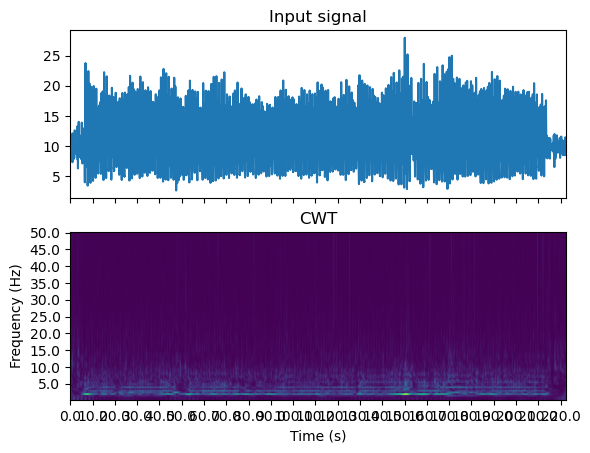

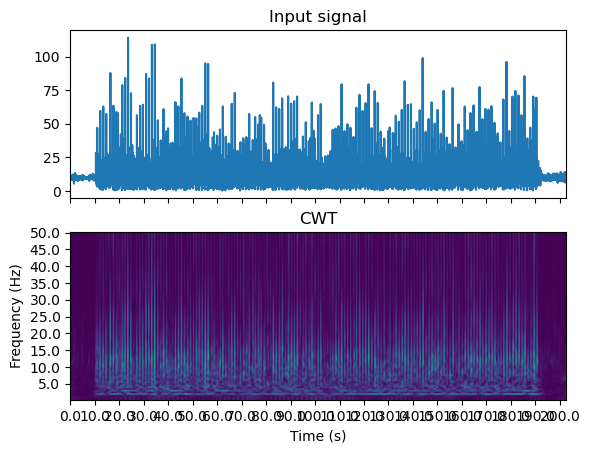

In [20]:
#plot cwt
fs = 100 # the sampling frequency, rounded to the nearest integer

fcwt.plot(frame["hand"].loc[one_walking].values, fs)
one_nordic = subject_activity(1,'Nordic walking')
fcwt.plot(frame["hand"].loc[one_nordic].values, fs)

## Building a classifier



So, to actually build a classifier, given that we have so few samples, we will need to choose some features. As a minimal model, lets use the average heart rate and the standard deviation of the magnitude of the acceleration of the hand IMU (the one plotted above).
First we need to create those variables



In [21]:
gb = frame.groupby(['activity label', 'subject'], sort='time')
aggregates = gb[['heart rate (bpm)', 'hand', 'ankle', 'chest']].aggregate([np.mean, np.std])
aggregates[np.isnan(aggregates).values]

heart rate (bpm)          hand         ankle      \
                                   mean std      mean std      mean std   
activity label subject                                                    
running        4             130.999962 NaN  9.907499 NaN  9.983255 NaN   
               4             130.999962 NaN  9.907499 NaN  9.983255 NaN   
               4             130.999962 NaN  9.907499 NaN  9.983255 NaN   
               4             130.999962 NaN  9.907499 NaN  9.983255 NaN   

                           chest      
                            mean std  
activity label subject                
running        4        9.846785 NaN  
               4        9.846785 NaN  
               4        9.846785 NaN  
               4        9.846785 NaN

We have a little detour to figure out why the standard deviation for subject 4 is a NaN.



In [22]:
frame[(frame['subject']==4) & (frame['activity label'] == 'running')]

,time,activity,heart rate (bpm),hand temperature,hand x,hand y,hand z,hand small x,hand small y,hand small z,...,chest gyro,ankle gyro,hand magne,chest magne,ankle magne,subject,Protocol,activity label,coarse activity,coarse activity label
231420,3301.46,5.0,130.999962,27.5,-4.61858,6.44599,-5.9394,-4.5911,6.38731,-5.98033,...,0.053439,0.015859,27.59614,25.645654,50.264433,4,True,running,2,exercise


It appears subject 4 didn&rsquo;t really record running, so we will have to drop that example as we move on to the classifier



In [23]:
aggregates.drop(('running', 4), axis=0,inplace=True)
aggregates.reset_index(inplace=True)
reg = linear_model.LogisticRegression(max_iter=10000)
reg.fit(aggregates.drop(['activity label', 'subject'], axis=1).values, aggregates['activity label'].values)
predictions = reg.predict(aggregates.drop(['activity label', 'subject'], axis=1).values)

/tmp/ipykernel_363578/3723468909.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  reg.fit(aggregates.drop(['activity label', 'subject'], axis=1).values, aggregates['activity label'].values)
/tmp/ipykernel_363578/3723468909.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  predictions = reg.predict(aggregates.drop(['activity label', 'subject'], axis=1).values)


So it trains; lets see how well it did (of course, given that this is without any sort of cross-validation, its use is somewhat questionable, but we have heavily constrained the model). Note that the confusion matrix doesn&rsquo;t have an equal number per class; the only example of car driving is misclassified as vacuuming.



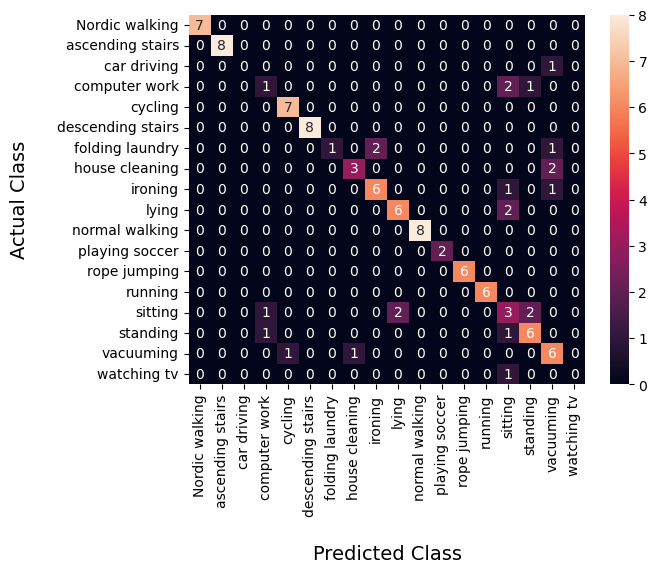

In [24]:
conf_mat = sklearn.metrics.confusion_matrix(aggregates['activity label'].values, predictions)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
ax.set_ylabel("Actual Class", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(reg.classes_, rotation=0)
ax.set_xlabel("Predicted Class", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(reg.classes_, rotation=90)
plt.show()

So the sedentary activities tend to get confused by this model, while house cleaning and vacuuming get confused. Any of the particularly active activities is easily separated from the rest. The resulting coefficients that got us here are in the heatmap below.



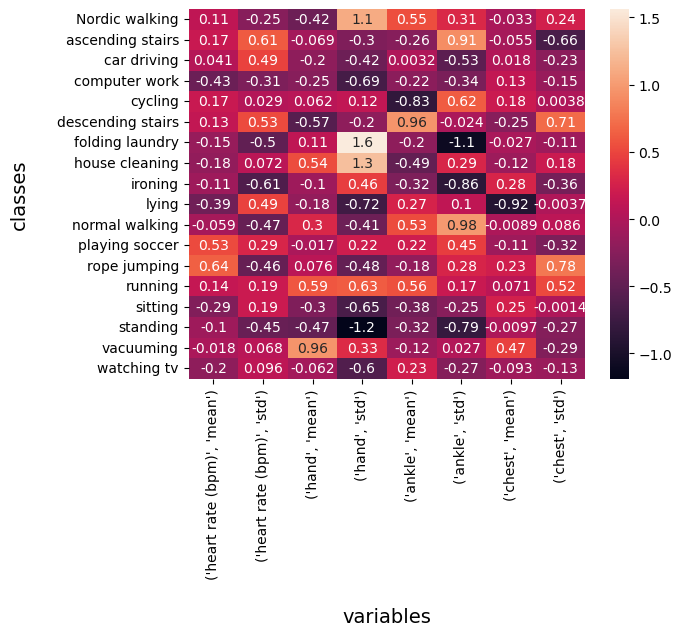

In [25]:
ax = sns.heatmap(reg.coef_, annot=True)
ax.set_ylabel("classes", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(reg.classes_, rotation=0)
ax.set_xlabel("variables", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(list(aggregates)[2:], rotation=90)
plt.show()

## Next steps



Looking at more of the signals with a wavelet transform would probably be worthwhile, and would be best done by writing a custom plot to get them all in the same figure in some way.
The model is ok, but there&rsquo;s obviously more variables to try with; ideally some sort of cross-validation scheme too, but having so few datapoints makes that somewhat difficult. Additionally, I noticed that not all of the activities are continuous, and I didn&rsquo;t have time to tease out the various sub-signals, which would get us more examples.
I would also like to try with other kinds of transforms; for example, taking the mean frequency, or only the heart rate after a start-up period.
Also, trying to predict based on the coarse labels would be worthwhile, though one can sort of see what would happen in the confusion matrix.

